In [100]:
import random

import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tsa import config
from tsa.modeling import ExpandingWindowForecaster

In [101]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [102]:
df = pd.read_csv(
    config.PROCESSED_DATA_DIR / "combined_stationary.csv", index_col=0, parse_dates=True
)
df.head()

,zwex_return,impi_return,inflation_rate,rate_change,vacancy_rate,gdp_growth,population_change_d
1993-07-01,-0.373241,-2.037327,-0.028898,-0.299,0.30,0.381316,-0.631895
1993-10-01,-0.307397,0.175953,0.506175,-0.338,0.30,0.547234,-0.017975
1994-01-01,1.156292,1.570735,0.107094,-0.002,0.42,0.562475,0.934411
1994-04-01,1.400267,-0.382496,0.459923,0.856,0.42,-0.831934,-0.168245
1994-07-01,1.249413,-0.496269,-0.481443,0.211,0.42,0.821735,-0.466957


We will now create two models, one including local variables like vacancy_rate and population_change_d, and one excluding those. We are trying to figure out if we can find $\alpha$ in these local variables.

### Model A: Macro variables

In [103]:
df_model_a = df[
    ["zwex_return", "impi_return", "inflation_rate", "rate_change", "gdp_growth"]
]

In [104]:
X_model_a = df_model_a[["impi_return", "inflation_rate", "rate_change", "gdp_growth"]]
y_a = df_model_a["zwex_return"]

In [105]:
scaler_a = StandardScaler()
X_scaled_a = scaler_a.fit_transform(X_model_a)

In [106]:
ridge_model_a = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_a.fit(X_scaled_a, y_a)

,"alphas alphas: array-like of shape (n_alphas,), default=(0.1, 1.0, 10.0)Array of alpha values to try.Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`.If using Leave-One-Out cross-validation, alphas must be strictly positive.","array([1.e-06...e+05, 1.e+06])"
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto false, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"scoring scoring: str, callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: negative :ref:`mean squared error ` if cv is None (i.e. when using leave-one-out cross-validation), or :ref:`coefficient of determination ` (:math:`R^2`) otherwise.",None
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the efficient Leave-One-Out cross-validation- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used, else,:class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",None
,"gcv_mode gcv_mode: {'auto', 'svd', 'eigen'}, default='auto'Flag indicating which strategy to use when performingLeave-One-Out Cross-Validation. Options are:: 'auto' : use 'svd' if n_samples > n_features, otherwise use 'eigen' 'svd' : force use of singular value decomposition of X when X is dense, eigenvalue decomposition of X^T.X when X is sparse. 'eigen' : force computation via eigendecomposition of X.X^TThe 'auto' mode is the default and is intended to pick the cheaperoption of the two depending on the shape of the training data.",None
,"store_cv_results store_cv_results: bool, default=FalseFlag indicating if the cross-validation values corresponding toeach alpha should be stored in the ``cv_results_`` attribute (seebelow). This flag is only compatible with ``cv=None`` (i.e. usingLeave-One-Out Cross-Validation)... versionchanged:: 1.5 Parameter name changed from `store_cv_values` to `store_cv_results`.",False
,"alpha_per_target alpha_per_target: bool, default=FalseFlag indicating whether to optimize the alpha value (picked from the`alphas` parameter list) for each target separately (for multi-outputsettings: multiple prediction targets). When set to `True`, afterfitting, the `alpha_` attribute will contain a value for each target.When set to `False`, a single alpha is used for all targets... versionadded:: 0.24",False


let's look at the ridge regression's coefficients:

          Feature  Coefficient
0     impi_return     0.211026
2     rate_change     0.149097
3      gdp_growth     0.028380
1  inflation_rate    -0.018157


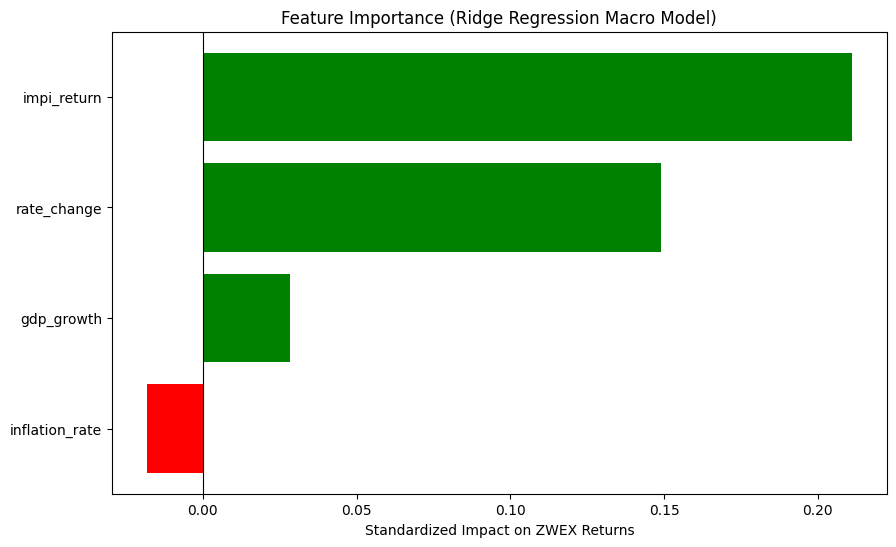

In [107]:
coef_df = pd.DataFrame(
    {
        "Feature": X_model_a.columns,
        "Coefficient": ridge_model_a.coef_,
    }
)

coef_df["Abs_Coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coef", ascending=False)

print(coef_df[["Feature", "Coefficient"]])

plt.figure(figsize=(10, 6))
colors = ["green" if x > 0 else "red" for x in coef_df["Coefficient"]]
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors)
plt.xlabel("Standardized Impact on ZWEX Returns")
plt.title("Feature Importance (Ridge Regression Macro Model)")
plt.axvline(0, color="black", linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

### Model B: incl. local variables

We need to make sure we incorporate our structural break in the vacancy rate

In [108]:
df_model_b = df.copy()
df_model_b["D_2000"] = (df_model_b.index >= "2000-01-01").astype(int)
df_model_b["D_vac"] = df_model_b["D_2000"] * df_model_b["vacancy_rate"]
df_model_b.tail()

,zwex_return,impi_return,inflation_rate,rate_change,vacancy_rate,gdp_growth,population_change_d,D_2000,D_vac
2023-10-01,1.615587,1.038672,0.228237,0.067,0.06,0.291901,-0.261519,1,0.06
2024-01-01,-1.064242,0.139429,-0.023062,-0.216,0.07,0.024514,-0.176416,1,0.07
2024-04-01,2.869959,-0.094574,0.986097,-0.137,0.07,1.007337,0.097097,1,0.07
2024-07-01,0.304814,-0.079679,0.096198,-0.243,0.07,0.423085,0.341753,1,0.07
2024-10-01,1.228211,-0.013089,-0.432383,0.001,0.07,0.152278,-0.423955,1,0.07


In [109]:
X_model_b = df_model_b.drop(columns=["zwex_return"])
y_b = df_model_b["zwex_return"]

In [110]:
scaler_b = StandardScaler()
X_scaled_b = scaler_b.fit_transform(X_model_b)

               Feature  Coefficient
3         vacancy_rate    -0.214972
6               D_2000     0.175021
2          rate_change     0.138279
7                D_vac     0.100734
0          impi_return     0.073980
5  population_change_d    -0.062817
4           gdp_growth     0.031025
1       inflation_rate    -0.012255


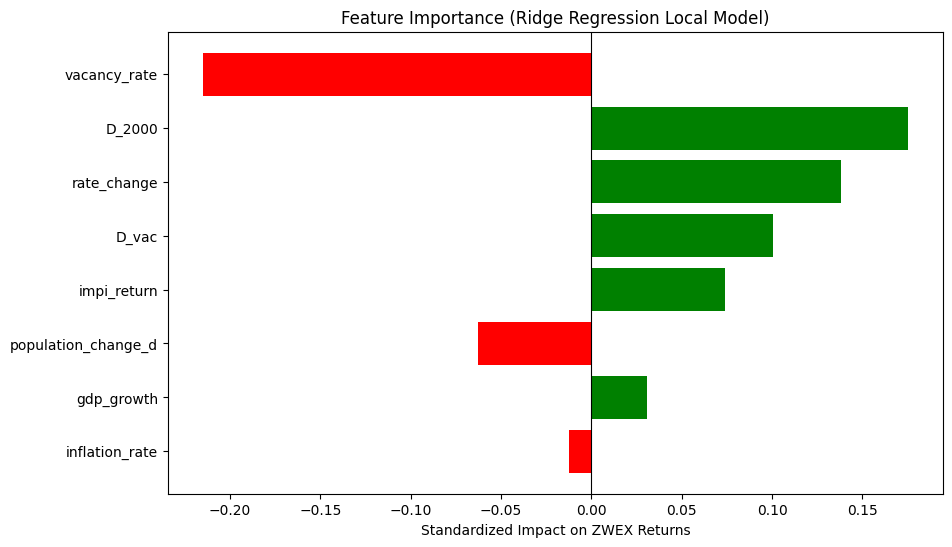

In [111]:
ridge_model_b = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_b.fit(X_scaled_b, y_b)

coef_df = pd.DataFrame(
    {
        "Feature": X_model_b.columns,
        "Coefficient": ridge_model_b.coef_,
    }
)

coef_df["Abs_Coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coef", ascending=False)

print(coef_df[["Feature", "Coefficient"]])

plt.figure(figsize=(10, 6))
colors = ["green" if x > 0 else "red" for x in coef_df["Coefficient"]]
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors)
plt.xlabel("Standardized Impact on ZWEX Returns")
plt.title("Feature Importance (Ridge Regression Local Model)")
plt.axvline(0, color="black", linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

## Bootstrapping

In order to get unbiased coefficients for Model B, we will apply bootstrapping to our Ridge Regression.

In [112]:
def bootstrap_ridge_coefficients(
    X, y, n_bootstrap=1000, alpha_range=np.logspace(-6, 6, 13), random_state=42
):
    np.random.seed(random_state)
    n_samples = len(X)
    bootstrap_coefs = []

    scaler = StandardScaler()

    for i in range(n_bootstrap):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X.iloc[indices]
        y_boot = y.iloc[indices]

        X_scaled = scaler.fit_transform(X_boot)
        model = RidgeCV(alphas=alpha_range)
        model.fit(X_scaled, y_boot)

        bootstrap_coefs.append(model.coef_)

    return np.array(bootstrap_coefs)


print("Running bootstrap ...")
bootstrap_coefs = bootstrap_ridge_coefficients(X_model_b, y_b, n_bootstrap=1000)
print("Bootstrap complete!")

Running bootstrap ...
Bootstrap complete!


Now we can caluclate confidence intervals from bootstrap distribution.

In [113]:
def calculate_ci(bootstrap_coefs, feature_names, confidence=0.95):
    alpha = 1 - confidence
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100

    results = []
    for i, feature in enumerate(feature_names):
        coef_distribution = bootstrap_coefs[:, i]
        mean_coef = np.mean(coef_distribution)
        std_coef = np.std(coef_distribution)
        ci_lower = np.percentile(coef_distribution, lower_percentile)
        ci_upper = np.percentile(coef_distribution, upper_percentile)

        significant = np.sign(ci_lower) == np.sign(
            ci_upper
        )  # check that 0 is not in the contained in the interval

        results.append(
            {
                "Feature": feature,
                "Mean_Coef": mean_coef,
                "Std": std_coef,
                "CI_Lower": ci_lower,
                "CI_Upper": ci_upper,
                "Significant": significant,
            }
        )

    return pd.DataFrame(results)


# Calculate 95% confidence intervals
ci_df = calculate_ci(bootstrap_coefs, X_model_b.columns, confidence=0.95)
ci_df = ci_df.sort_values("Mean_Coef", key=abs, ascending=False)
print(ci_df)

               Feature  Mean_Coef       Std  CI_Lower  CI_Upper  Significant
3         vacancy_rate  -0.355817  0.381337 -1.456911 -0.050515         True
2          rate_change   0.167981  0.102937  0.011520  0.422066         True
7                D_vac   0.137038  0.176871 -0.112170  0.631558        False
6               D_2000   0.079292  0.356664 -0.969463  0.484309        False
5  population_change_d  -0.071411  0.112530 -0.334703  0.110544        False
4           gdp_growth   0.041696  0.067266 -0.085594  0.191298        False
0          impi_return   0.041029  0.122473 -0.257673  0.243576        False
1       inflation_rate  -0.027335  0.102802 -0.276024  0.158353        False


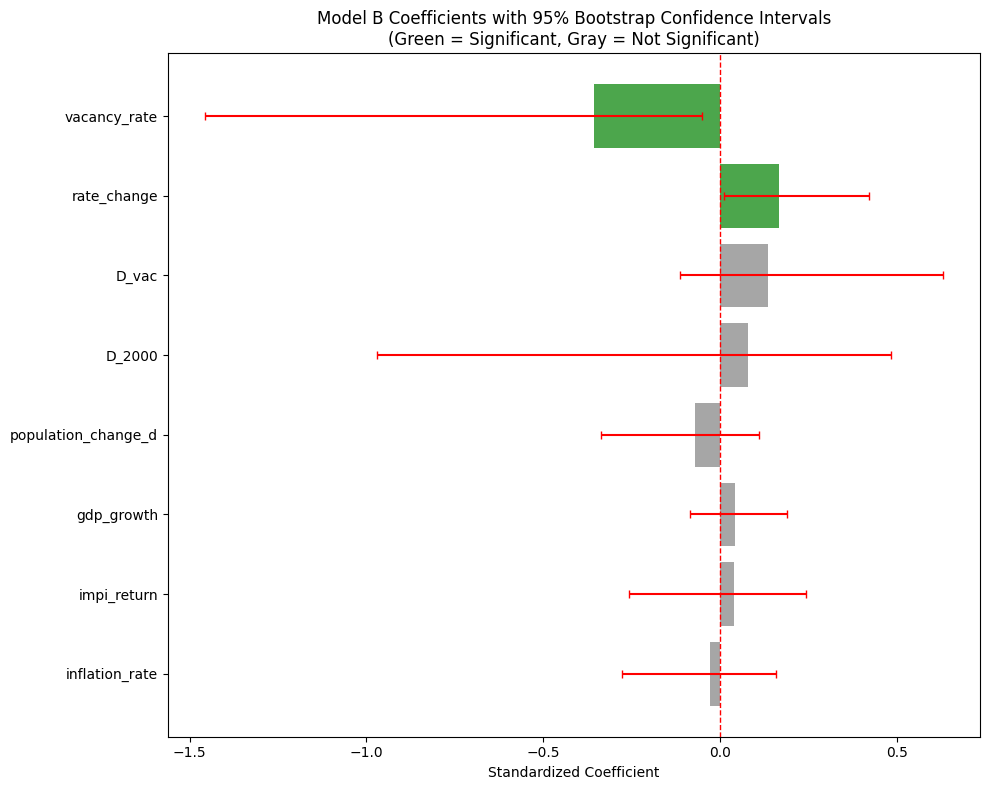

In [114]:
fig, ax = plt.subplots(figsize=(10, 8))

ci_sorted = ci_df.sort_values("Mean_Coef", key=abs, ascending=True)

y_pos = np.arange(len(ci_sorted))
colors = ["green" if sig else "gray" for sig in ci_sorted["Significant"]]

ax.barh(
    y_pos, ci_sorted["Mean_Coef"], color=colors, alpha=0.7, label="Mean Coefficient"
)

ax.errorbar(
    ci_sorted["Mean_Coef"],
    y_pos,
    xerr=[
        ci_sorted["Mean_Coef"] - ci_sorted["CI_Lower"],
        ci_sorted["CI_Upper"] - ci_sorted["Mean_Coef"],
    ],
    fmt="none",
    color="red",
    capsize=3,
    linewidth=1.5,
)

ax.axvline(0, color="red", linestyle="--", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_sorted["Feature"])
ax.set_xlabel("Standardized Coefficient")
ax.set_title(
    "Model B Coefficients with 95% Bootstrap Confidence Intervals\n(Green = Significant, Gray = Not Significant)"
)
plt.tight_layout()
plt.show()

## Expanding Window Recursive Estimation
This approach re-estimates the model at each time step using all available historical data, providing more robust out-of-sample forecasts.

In [115]:
forecaster = ExpandingWindowForecaster(initial_window=0.6, random_state=42)

# Model A (Macro only)
df_forecast_a = df_model_a.copy()
pred_a, actual_a, idx_a = forecaster.ridge(df_forecast_a, target_col="zwex_return")

# Model B (Macro + Local)
df_forecast_b = df_model_b.copy()
pred_b, actual_b, idx_b = forecaster.ridge(df_forecast_b, target_col="zwex_return")

Now we can compare model performance

In [116]:
mse_a = mean_squared_error(actual_a, pred_a)
mse_b = mean_squared_error(actual_b, pred_b)
rmse_a = np.sqrt(mse_a)
rmse_b = np.sqrt(mse_b)

print(f"Forecast period: {idx_a[0]} to {idx_a[-1]} ({len(idx_a)} observations)")
print(f"\nModel A (Macro Only):")
print(f"    MSE:  {mse_a:.6f}")
print(f"    RMSE: {rmse_a:.6f}")
print(f"\nModel B (Macro + Local):")
print(f"    MSE:  {mse_b:.6f}")
print(f"    RMSE: {rmse_b:.6f}")
print(f"\nImprovement (MSE):  {(mse_a - mse_b)/mse_a * 100:.2f}%")
print(f"Improvement (RMSE): {(rmse_a - rmse_b)/rmse_a * 100:.2f}%")

Forecast period: 2012-04-01 00:00:00 to 2024-10-01 00:00:00 (51 observations)

Model A (Macro Only):
    MSE:  1.463806
    RMSE: 1.209879

Model B (Macro + Local):
    MSE:  1.315177
    RMSE: 1.146812

Improvement (MSE):  10.15%
Improvement (RMSE): 5.21%


We save the results for comparison in another notebook.

In [117]:
ridge_macro_results = {
    "predictions": pred_a,
    "actuals": actual_a,
    "index": idx_a,
    "mse": mse_a,
    "rmse": rmse_a,
}

ridge_local_results = {
    "predictions": pred_b,
    "actuals": actual_b,
    "index": idx_b,
    "mse": mse_b,
    "rmse": rmse_b,
}

joblib.dump(
    ridge_macro_results, config.MODELS_DIR / "ridge_macro_forecast_results.joblib"
)
joblib.dump(
    ridge_local_results, config.MODELS_DIR / "ridge_local_forecast_results.joblib"
)

print("Ridge forecast results saved!")

Ridge forecast results saved!
